# Athens Airbnb Inference Analysis of Listing Price

#### STAT 301 - Group 31: Angela Li, Tyler Yih, Rex Ren, Diamond Wang (Dec. 6th, 2025)

## Introduction

## 2. Scientific Question

#### Clearly state the question you want try to answer using the dataset

- We want to examine the association between the price of the accommodation for two people staying two nights (response) and predictors related to room characteristics (e.g. room type, number of bedrooms), location information (e.g. distance from city centre, longitude, latitude), and the attraction index.
- The response is `real_sum`, the price of the accommodation for two people staying two nights in Euros.
- Our question is primarily focused on inference, as we are identifying which features are associated with price and estimating their effects. We may build a predictive model later and keep our options open.

## Method and Results

### a) Data

#### Loading data

In [ ]:
# Run this cell before continuing.
library(tidyverse)
library(repr)
library(infer)
library(cowplot)
library(broom)
library(GGally)
library(modelr)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2


Attaching package: ‘modelr’


The following object is masked from ‘package:broom’:

    bootstrap




In [ ]:
# Airbnb data in Athens on weekdays
weekdays <- read_csv("https://raw.githubusercontent.com/tyih985/athens-airbnb/refs/heads/main/data/athens_weekdays.csv")
# Airbnb data in Athens on weekends
weekends <- read_csv("https://raw.githubusercontent.com/tyih985/athens-airbnb/refs/heads/main/data/athens_weekends.csv")

New names:
• `` -> `...1`
New names:
• `` -> `...1`


#### Source and information
- The data was collected with web-scraping done with the help of a web-automation framework (Selenium WebDriver) during a study done by Gyódi, Kristóf and Nawaro, Łukasz, and attractiveness was based on TripAdvisor data.
- The data, provided by the University of Warsaw, was used to collect Airbnb offers that would be presented to a real user.

#### Citation
- https://doi.org/10.5281/zenodo.4446043
- https://doi.org/10.1016/j.tourman.2021.104319

### Variables

#### Descriptive summary
- Our assigned dataset offers detailed information on Airbnb listings in Athens, Greece, for both weekdays and weekends.
- The weekdays dataset consists of 2,653 entries, and the weekends dataset consists of 2,627 entries.
- Both datasets have 20 variables, whose names, descriptions, and types are provided in the table below.

#### Pre-selection of variables
- We likely will drop `room_shared`, and `room_private,` as `room_type` has overlapping information with the booleans about the type of room in the listing.
- In addition, both `attr_index` and `rest_index` heavily overlap with their normalized counterparts, so we only need to use one; likely the normalized version, so we would drop `attr_index` and `rest_index`.
- The index column does not contain very useful information so we would drop that as well.
- Lastly, we will remove `lng` and `lat` since we don't cover spatial analysis in this course.

| Variable Name                 | Description                                                     | Type        |
|-------------------------------|-----------------------------------------------------------------|-------------|
| `(index)`                     | Index of the row in the table                                   | Numeric     |
| `realSum`                     | Full price of accommodation for two people and two nights (EUR) | Numeric     |
| `room_type`                   | Type of the accommodation                                       | Categorical |
| `room_shared`                 | Whether the room is shared                                      | Boolean     |
| `room_private`                | Whether the room is private                                     | Boolean     |
| `person_capacity`             | Maximum number of guests                                        | Numeric     |
| `host_is_superhost`           | Whether the host is a superhost                                 | Boolean     |
| `multi`                       | Whether the listing belongs to hosts with 2-4 offers            | Boolean     |
| `biz`                         | Whether the listing belongs to hosts with more than 4 offers    | Boolean     |
| `cleanliness_rating`          | Cleanliness rating of the listing                               | Numeric     |
| `guest_satisfaction_overall`  | Overall guest satisfaction rating                               | Numeric     |
| `bedrooms`                    | Number of bedrooms in the listing (0 for studios)               | Numeric     |
| `dist`                        | Distance from the city centre (km)                              | Numeric     |
| `metro_dist`                  | Distance from the nearest metro station (km)                    | Numeric     |
| `attr_index`                  | Attraction index of the listing location                        | Numeric     |
| `attr_index_norm`             | Normalized attraction index (0-100)                             | Numeric     |
| `rest_index`                  | Restaurant index of the listing location                        | Numeric     |
| `rest_index_norm`             | Normalized restaurant index (0-100)                             | Numeric     |
| `lng`                         | Longitude of the listing location                               | Numeric     |
| `lat`                         | Latitude of the listing location                                | Numeric     |


### b) Exploratory Data Analysis (EDA)

#### Clean/wrangling data

In [4]:
# combine weekday and weekend datasets, creating new 
athens_raw <- bind_rows(
  mutate(weekdays, day_type = "weekday"),
  mutate(weekends, day_type = "weekend")
)

head(athens_raw)

...1,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,⋯,bedrooms,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat,day_type
<dbl>,<dbl>,<chr>,<lgl>,<lgl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0,129.82448,Entire home/apt,FALSE,FALSE,4,FALSE,0,0,10,⋯,2,2.8139635,0.8818900,55.34857,2.086871,78.77838,5.915160,23.76600,37.98300,weekday
1,138.96375,Entire home/apt,FALSE,FALSE,4,TRUE,1,0,10,⋯,1,0.4072929,0.3045679,240.30665,9.060559,407.16770,30.572629,23.73168,37.97776,weekday
2,156.30492,Entire home/apt,FALSE,FALSE,3,TRUE,0,1,10,⋯,1,1.2372111,0.2884881,199.50737,7.522257,395.96740,29.731642,23.72200,37.97900,weekday
3,91.62702,Entire home/apt,FALSE,FALSE,4,TRUE,1,0,10,⋯,1,4.3674572,0.2974673,39.80305,1.500740,58.70658,4.408047,23.72712,38.01435,weekday
4,74.05151,Private room,FALSE,TRUE,2,FALSE,0,0,10,⋯,1,2.1941850,0.3852657,78.73340,2.968577,113.32597,8.509204,23.73391,37.99529,weekday
5,113.88934,Entire home/apt,FALSE,FALSE,6,TRUE,1,0,10,⋯,2,2.0712056,0.4538674,96.58899,3.641806,158.64432,11.911981,23.71584,37.98598,weekday


In [9]:
athens <- athens_raw %>%
    # rename realSum
    rename(real_sum = realSum) %>%
    mutate(
        # convert room_type to factor
        room_type = fct_recode(room_type,
                                "entire" = "Entire home/apt",
                                "private" = "Private room",
                                "shared" = "Shared room"),
        # convert day_type to factor
        day_type = as_factor(day_type),
        
        # create a new categorical column 'num_host_offers'
        num_host_offers = case_when(
          biz == 1 ~ "moreThanFour",
          multi == 1 ~ "twoToFour",
          TRUE ~ "one"
        ),
        
        # make num_host_offers a factor
        num_host_offers = as_factor(num_host_offers)
    ) %>% 

    # remove index, room_shared, room_private, multi, biz, attr_index, rest_index and longitude and latitude (since we cannot do spatial analysis)
    select(-...1, -room_shared, -room_private, -multi, -biz, -attr_index, -rest_index, -lng, -lat)

head(athens)

real_sum,room_type,person_capacity,host_is_superhost,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index_norm,rest_index_norm,day_type,num_host_offers
<dbl>,<fct>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
129.82448,entire,4,FALSE,10,100,2,2.8139635,0.8818900,2.086871,5.915160,weekday,one
138.96375,entire,4,TRUE,10,96,1,0.4072929,0.3045679,9.060559,30.572629,weekday,twoToFour
156.30492,entire,3,TRUE,10,98,1,1.2372111,0.2884881,7.522257,29.731642,weekday,moreThanFour
91.62702,entire,4,TRUE,10,99,1,4.3674572,0.2974673,1.500740,4.408047,weekday,twoToFour
74.05151,private,2,FALSE,10,100,1,2.1941850,0.3852657,2.968577,8.509204,weekday,one
113.88934,entire,6,TRUE,10,96,2,2.0712056,0.4538674,3.641806,11.911981,weekday,twoToFour


#### Visualizations

##### 1. Boxplot

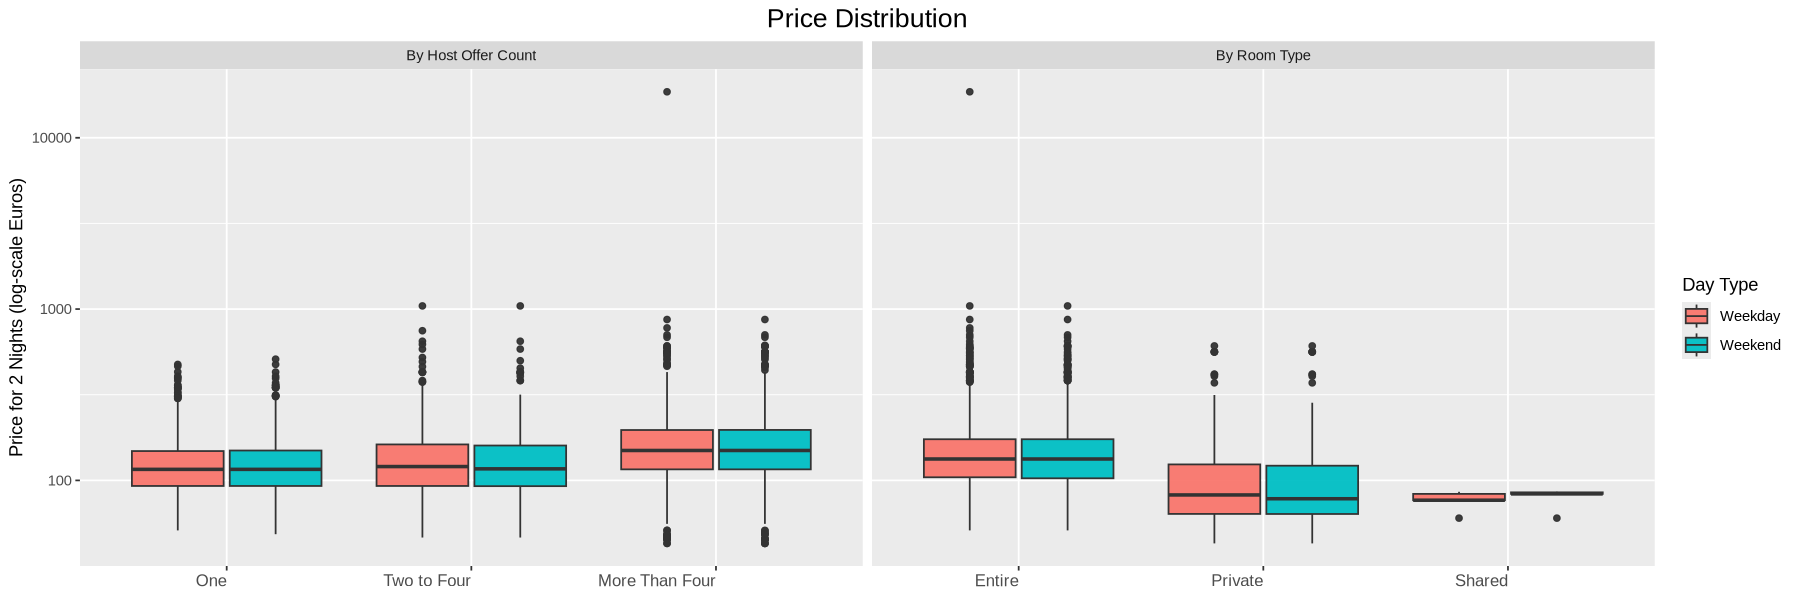

In [45]:
# Adjust these so the plots fit correctly to your screen!
options(repr.plot.width = 15, repr.plot.height = 5)

p_facet <- athens %>%
  pivot_longer(
    cols = c(room_type, num_host_offers),
    names_to = "facet_var",
    values_to = "facet_value"
  ) %>%
  ggplot(aes(x = facet_value, y = real_sum, fill = day_type)) +
  geom_boxplot(position = position_dodge(width = 0.8), alpha = 0.95) +
  scale_y_log10() +
  scale_x_discrete(
    labels = function(x) case_when(
      x == "moreThanFour" ~ "More Than Four",
      x == "one" ~ "One",
      x == "twoToFour" ~ "Two to Four",
      TRUE ~ str_to_title(x)
    )
  ) +
  scale_fill_discrete(labels = function(x) str_to_title(x)) +
  facet_wrap(
    ~ facet_var,
    scales = "free_x",
    labeller = as_labeller(c(
      room_type = "By Room Type",
      num_host_offers = "By Host Offer Count"
    ))
  ) +
  labs(
    x = NULL,
    y = "Price for 2 Nights (log-scale Euros)",
    fill = "Day Type",
    title = "Price Distribution"
  ) +
  theme(
    legend.position = "right",
    plot.title = element_text(size = 16, hjust = 0.5),
    axis.text.x = element_text(vjust = 1, hjust = 1, size = 10)
  )

p_facet

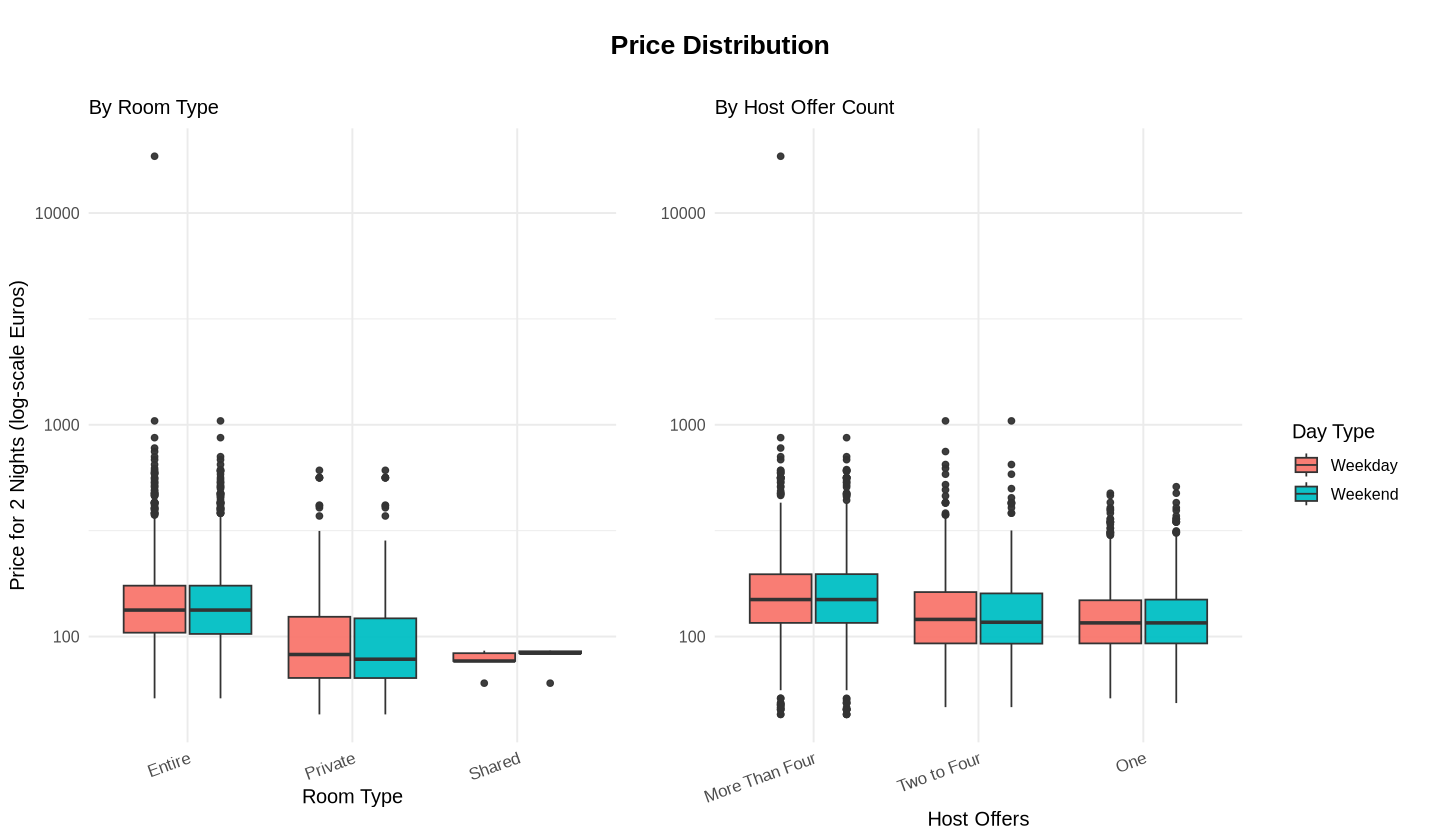

In [18]:
options(repr.plot.width = 12, repr.plot.height = 7)
p1 <- ggplot(athens, aes(x = room_type, y = real_sum, fill = day_type)) +
  geom_boxplot(position = position_dodge(width = 0.8), alpha = 0.95) +
  scale_y_log10() +
  scale_x_discrete(labels = function(x) str_to_title(x)) +
  scale_fill_discrete(labels = function(x) str_to_title(x)) +
  labs(
    x = "Room Type",
    y = "Price for 2 Nights (log-scale Euros)",
    fill = "Day Type"
  ) +
  theme_minimal(base_size = 12) +
  theme(
    legend.position = "top",
    strip.text = element_text(face = "bold"),
    plot.title = element_text(hjust = 0.5, size = 14, margin = margin(b = 10)),
    axis.text.x = element_text(angle = 20, vjust = 1, hjust = 1, size = 10)
  )

p2 <- ggplot(athens, aes(x = num_host_offers, y = real_sum, fill = day_type)) +
  geom_boxplot(position = position_dodge(width = 0.8), alpha = 0.95) +
  scale_y_log10() +
  scale_x_discrete(
    labels = function(x) case_when(
      x == "moreThanFour" ~ "More Than Four",
      x == "one" ~ "One",
      x == "twoToFour" ~ "Two to Four",
      TRUE ~ str_to_title(x)
    )) +
  scale_fill_discrete(labels = function(x) str_to_title(x)) +
  labs(
    x = "Host Offers",
    y = NULL,
    fill = "Day Type"
  ) +
  theme_minimal(base_size = 12) +
  theme(
    legend.position = "top",
    strip.text = element_text(face = "bold"),
    plot.title = element_text(hjust = 0.5, size = 14, margin = margin(b = 10)),
    axis.text.x = element_text(angle = 20, vjust = 1, hjust = 1, size = 10)
  )

legend <- get_legend(p1 + theme(legend.position = "right"))

plot_grid(
  ggdraw() + 
    draw_label(
      "Price Distribution", 
      fontface = 'bold', 
      x = 0.5, 
      hjust = 0.5,
      size = 16
    ),
  plot_grid(
    plot_grid(
      p1 + labs(subtitle = "By Room Type", title = NULL) + theme(legend.position = "none"),
      p2 + labs(subtitle = "By Host Offer Count", title = NULL) + theme(legend.position = "none"),
      ncol = 2,
      align = "hv",
      axis = "tblr",
      rel_widths = c(1, 1)
    ),
    legend,
    ncol = 2,
    rel_widths = c(1, 0.15)
  ),
  ncol = 1,
  rel_heights = c(0.12, 1)
)

##### Relevance
- These boxplots are relevant because they shows how the response (`real_sum`) varies across two key categorical predictors (`room_type` and `num_host_offers`), and how that relationship shifts by `day_type`.
- Using boxplots on a log10 y-scale makes the skewed price distribution easier to compare and helps spot group-level differences and heteroscedasticity that are important for later inference.
##### Interpretation of Results
- `entire` Airbnb offers show substantially higher medians and much wider variability than `private` or `shared` offerings, and the `entire` category contains extreme high-price outliers that extend far above the rest of the distribution.
- `shared` appears very narrow and has few observations.
##### What is Learned
- The visualization suggests `room_type` and `num_host_offers` are promising predictors to include (and possibly interact) in a regression for inference, and it justifies the log-transform of price.
- It also reveals various problems to address in modelling, such as strong right skew and outliers, unequal group sizes, and confounding from variables that we haven't explored yet.

##### 2. Violin Plot

<<<<<<< local


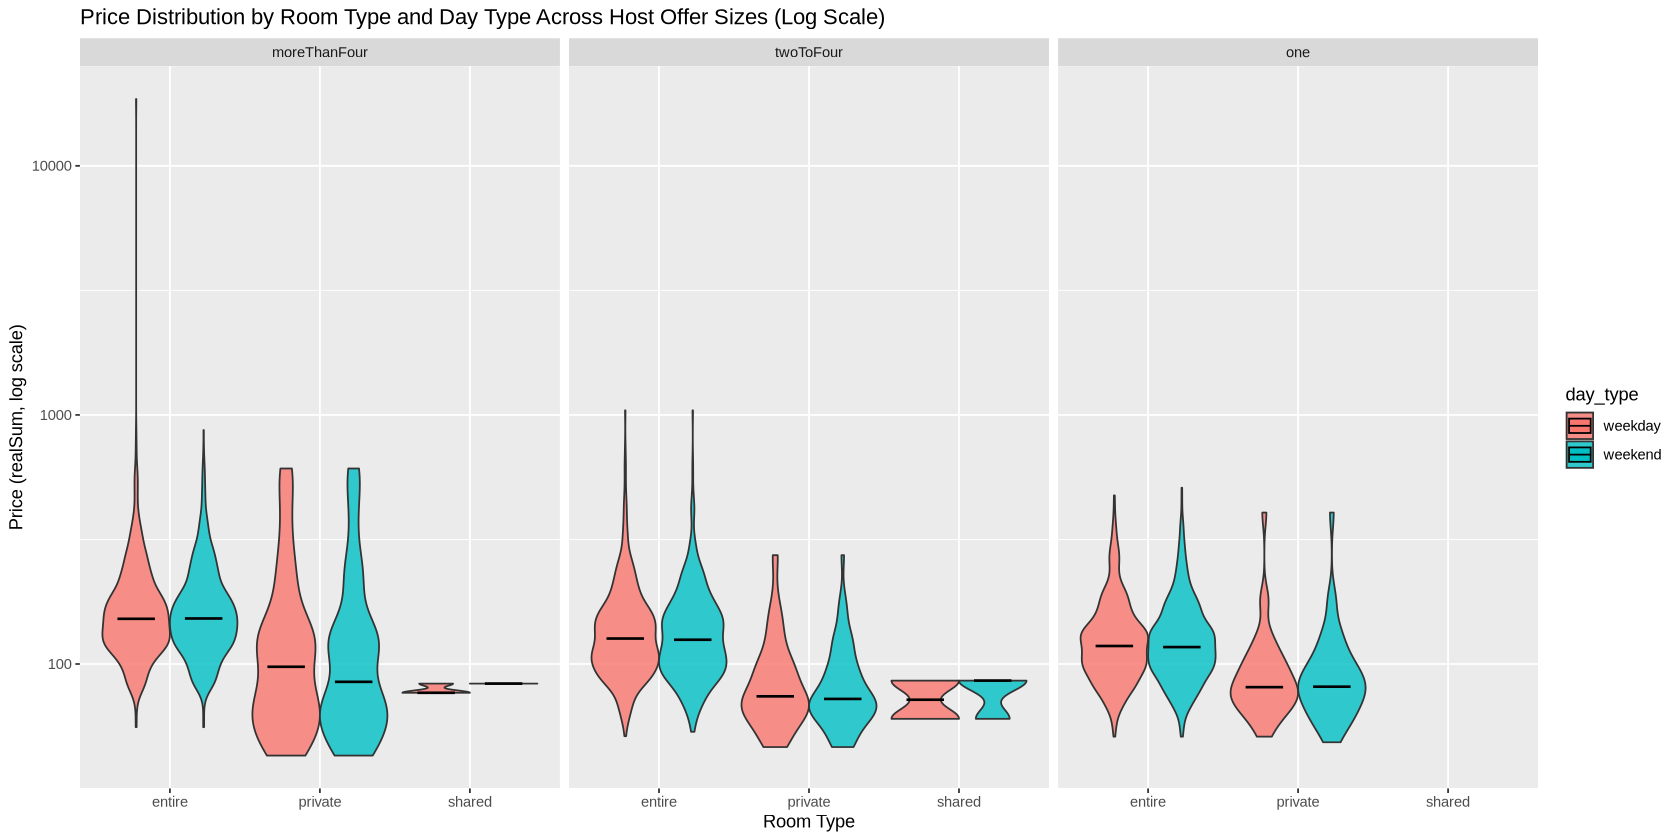

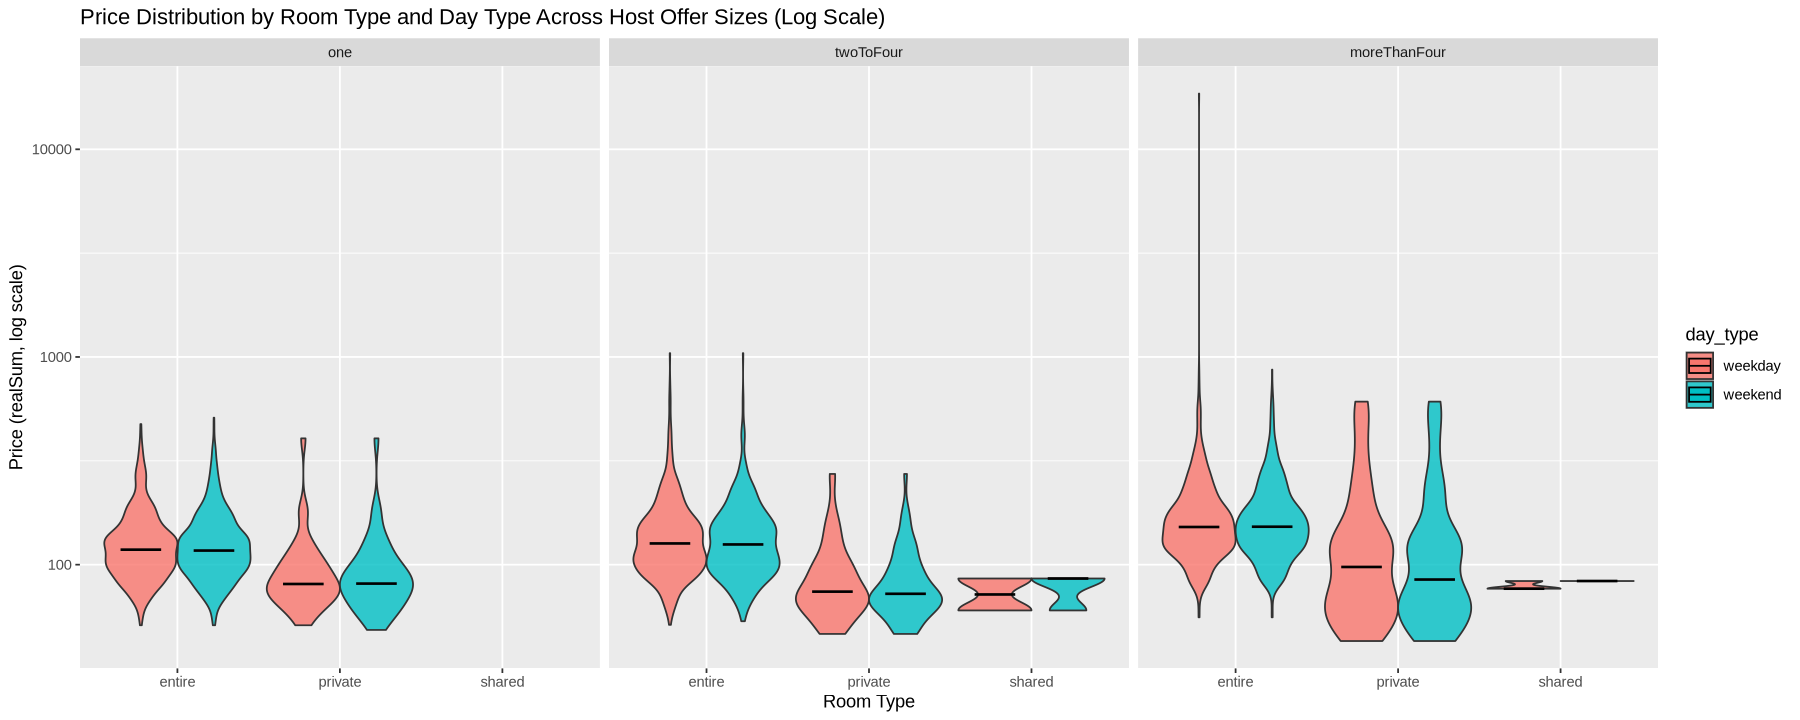

>>>>>>> remote


In [ ]:
options(repr.plot.width = 20, repr.plot.height = 8)

ggplot(athens, aes(x = room_type, y = realSum, fill = day_type)) +
  geom_violin(scale = "width", trim = TRUE, alpha = 0.8, position = position_dodge(width = 0.9)) +
  stat_summary(
    fun = median,
    geom = "crossbar",
    width = 0.5,
    color = "black",
    fatten = 1.5,
    position = position_dodge(width = 0.9)
  ) +
  scale_y_log10() +
  facet_wrap(~ num_host_offers) +
  labs(
    title = "Price Distribution by Room Type and Day Type Across Host Offer Sizes (Log Scale)",
    y = "Price (realSum, log scale)",
    x = "Room Type"
  )

##### Relevance
- These violin plots are relevant to address the question and explores the data because it visually explores how accommodation prices (realSum) vary by room type, weekday vs weekend, and number of host offers, which are all key variables related to room characteristics and timing of stay which may influence pricing.
- Faceting by host offer size allows us to compare pricing patterns across hosts with few versus many listings and look at the variability across the categories.

##### Interpretation of Results
- The original data is heavily right-skewed, so we log-transformed the price axis to reduce skewness.
- For weekday vs. weekend, price distributions are similar for some room type x host offer size combinations (e.g., entire rooms or private rooms with one or two-to-four listings) and show small differences for others (e.g. shared rooms or private rooms with more-than-four listings), while for room type, entire homes remain the most expensive and shared and private rooms have lower, more stable prices.
- The violin plots reveal that price distributions across room types deviate from normality, as several have long upper tails, and some show two distinct peaks, indicating bimodality.

##### What is Learned
- Price does not appear to differ consistently between weekdays and weekends, whereas room type shows a clearer relationship with price.
- A prominent outlier in the weekday × entire room × more-than-four-listings category suggests an unusually high-priced property that could distort model estimates if not addressed.
- The long upper tails in several distributions, even on the log scale, indicate residual skewness and possible heteroskedasticity, which could violate regression assumptions and should be considered in modeling.

#### Summary Tables

In [38]:
# get summary of the dataset
summary(athens)

    real_sum          room_type    person_capacity host_is_superhost
 Min.   :   42.88   entire :4872   Min.   :2.000   Mode :logical    
 1st Qu.:   98.66   private: 397   1st Qu.:3.000   FALSE:3017       
 Median :  127.72   shared :  11   Median :4.000   TRUE :2263       
 Mean   :  151.74                  Mean   :3.698                    
 3rd Qu.:  171.54                  3rd Qu.:4.000                    
 Max.   :18545.45                  Max.   :6.000                    
 cleanliness_rating guest_satisfaction_overall    bedrooms    
 Min.   : 2.000     Min.   : 20                Min.   :0.000  
 1st Qu.: 9.000     1st Qu.: 94                1st Qu.:1.000  
 Median :10.000     Median : 97                Median :1.000  
 Mean   : 9.638     Mean   : 95                Mean   :1.271  
 3rd Qu.:10.000     3rd Qu.:100                3rd Qu.:2.000  
 Max.   :10.000     Max.   :100                Max.   :4.000  
      dist           metro_dist      attr_index_norm   rest_index_norm   
 M

We can see the means, medians, min, max for the numeric columns, and we can see the number of rows corresponding to each category for the categorical columns.

In [39]:
# get number of N/As in the dataset
colSums(is.na(athens))

real_sum                  room_type 
                         0                          0 
           person_capacity          host_is_superhost 
                         0                          0 
        cleanliness_rating guest_satisfaction_overall 
                         0                          0 
                  bedrooms                       dist 
                         0                          0 
                metro_dist            attr_index_norm 
                         0                          0 
           rest_index_norm                   day_type 
                         0                          0 
           num_host_offers 
                         0

There are no N/As in our dataset.

### c) Method and Plan 

#### Proposed Method
We use a **multiple linear regression (MLR)** model to predict the log-transformed accommodation price, (i.e. `log(real_sum)`, using the predictors:  
`room_type`, `day_type`, `person_capacity`, `host_is_superhost`, `cleanliness_rating`, `guest_satisfaction_overall`, `bedrooms`, `dist`, `metro_dist`, `attr_index`, `rest_index`, `rest_index_norm`, and `num_host_offers`). 
Since spatial analysis is not covered in this course, we do not use `lat` nor `lng`.

##### Justification
- MLR allows us to estimate how each listing characteristic is associated with price while controlling for other factors, producing interpretable coefficient estimates and hypothesis tests.  
- Log-transforming `real_sum` reduces right skew, stabilizes variance, and converts multiplicative effects into additive ones, allowing coefficients to be interpreted approximately as percentage changes in price.

##### Required Assumptions
- This method assumes:
  - Linearity: predictors have a linear relationship with `log(real_sum)` (or are appropriately encoded/transformed).  
  - Independence: listings are treated as independent observations.  
  - Error structure: residuals are assumed to be roughly homoskedastic and approximately normally distributed for standard inference.  
  - Low multicollinearity: predictors should not be excessively correlated to ensure stable coefficient estimates.

##### Potential Limitations and Weaknesses
- The linear model cannot naturally capture nonlinear relationships or interactions unless explicitly included.  
- Outliers and influential listings may still affect estimates even after a log-transform.  
- Violations of homoskedasticity or normality may lead to unreliable standard errors and p-values.  
- Categorical variables with many levels require dummy encoding, which may increase model complexity.


#### Model Assessment Plan

TODO!!

### d) Code and Results

In [1]:
# Attach packages
library(tidyverse)
library(repr)
library(infer)
library(cowplot)
library(broom)
library(GGally)
library(modelr)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2


Attaching package: ‘modelr’


The following object is masked from ‘package:broom’:

    bootstrap




In [2]:
# Airbnb data in Athens on weekdays
weekdays <- read_csv("https://raw.githubusercontent.com/tyih985/athens-airbnb/refs/heads/main/data/athens_weekdays.csv")
# Airbnb data in Athens on weekends
weekends <- read_csv("https://raw.githubusercontent.com/tyih985/athens-airbnb/refs/heads/main/data/athens_weekends.csv")

New names:
• `` -> `...1`
Rows: 2653 Columns: 20
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): room_type
dbl (16): ...1, realSum, person_capacity, multi, biz, cleanliness_rating, gu...
lgl  (3): room_shared, room_private, host_is_superhost

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
New names:
• `` -> `...1`
Rows: 2627 Columns: 20
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): room_type
dbl (16): ...1, realSum, person_capacity, multi, biz, cleanliness_rating, gu...
lgl  (3): room_shared, room_private, host_is_superhost

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
# combine weekday and weekend datasets, creating new 
athens_raw <- bind_rows(
  mutate(weekdays, day_type = "weekday"),
  mutate(weekends, day_type = "weekend")
)

head(athens_raw)

...1,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,⋯,bedrooms,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat,day_type
<dbl>,<dbl>,<chr>,<lgl>,<lgl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0,129.82448,Entire home/apt,FALSE,FALSE,4,FALSE,0,0,10,⋯,2,2.8139635,0.8818900,55.34857,2.086871,78.77838,5.915160,23.76600,37.98300,weekday
1,138.96375,Entire home/apt,FALSE,FALSE,4,TRUE,1,0,10,⋯,1,0.4072929,0.3045679,240.30665,9.060559,407.16770,30.572629,23.73168,37.97776,weekday
2,156.30492,Entire home/apt,FALSE,FALSE,3,TRUE,0,1,10,⋯,1,1.2372111,0.2884881,199.50737,7.522257,395.96740,29.731642,23.72200,37.97900,weekday
3,91.62702,Entire home/apt,FALSE,FALSE,4,TRUE,1,0,10,⋯,1,4.3674572,0.2974673,39.80305,1.500740,58.70658,4.408047,23.72712,38.01435,weekday
4,74.05151,Private room,FALSE,TRUE,2,FALSE,0,0,10,⋯,1,2.1941850,0.3852657,78.73340,2.968577,113.32597,8.509204,23.73391,37.99529,weekday
5,113.88934,Entire home/apt,FALSE,FALSE,6,TRUE,1,0,10,⋯,2,2.0712056,0.4538674,96.58899,3.641806,158.64432,11.911981,23.71584,37.98598,weekday


In [4]:
athens <- athens_raw %>%
    # rename realSum
    rename(real_sum = realSum) %>%
    mutate(
        # convert room_type to factor
        room_type = fct_recode(room_type,
                                "entire" = "Entire home/apt",
                                "private" = "Private room",
                                "shared" = "Shared room"),
        # convert day_type to factor
        day_type = as_factor(day_type),
        
        # create a new categorical column 'num_host_offers'
        num_host_offers = case_when(
          biz == 1 ~ "moreThanFour",
          multi == 1 ~ "twoToFour",
          TRUE ~ "one"
        ),
        
        # make num_host_offers a factor
        num_host_offers = as_factor(num_host_offers)
    ) %>% 

    # remove index, room_shared, room_private, multi, biz, attr_index, rest_index and longitude and latitude (since we cannot do spatial analysis)
    select(-...1, -room_shared, -room_private, -multi, -biz, -attr_index, -rest_index, -lng, -lat)

head(athens)

real_sum,room_type,person_capacity,host_is_superhost,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index_norm,rest_index_norm,day_type,num_host_offers
<dbl>,<fct>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
129.82448,entire,4,FALSE,10,100,2,2.8139635,0.8818900,2.086871,5.915160,weekday,one
138.96375,entire,4,TRUE,10,96,1,0.4072929,0.3045679,9.060559,30.572629,weekday,twoToFour
156.30492,entire,3,TRUE,10,98,1,1.2372111,0.2884881,7.522257,29.731642,weekday,moreThanFour
91.62702,entire,4,TRUE,10,99,1,4.3674572,0.2974673,1.500740,4.408047,weekday,twoToFour
74.05151,private,2,FALSE,10,100,1,2.1941850,0.3852657,2.968577,8.509204,weekday,one
113.88934,entire,6,TRUE,10,96,2,2.0712056,0.4538674,3.641806,11.911981,weekday,twoToFour


In [ ]:
mlr_fit <- lm(formula = log(real_sum) ~ ., data = athens)

mlr_res <- tidy(mlr_fit, conf.int = TRUE) |>
    mutate_if(is.numeric, round, 2)

mlr_res

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),3.76,0.06,59.61,0.00,3.64,3.88
room_typeprivate,-0.27,0.02,-14.93,0.00,-0.30,-0.23
room_typeshared,-0.49,0.10,-4.89,0.00,-0.68,-0.29
person_capacity,0.07,0.00,14.96,0.00,0.06,0.08
host_is_superhostTRUE,0.03,0.01,2.90,0.00,0.01,0.05
cleanliness_rating,0.05,0.01,6.48,0.00,0.04,0.07
guest_satisfaction_overall,0.00,0.00,1.32,0.19,0.00,0.00
bedrooms,0.12,0.01,13.04,0.00,0.10,0.14
dist,-0.08,0.01,-13.25,0.00,-0.09,-0.07


#### Interpretation of Results

- **Expected associations:** `room_type = private` and `room_type = shared` are priced significantly lower than `room_type = entire`, and price increases with `person_capacity`, `bedrooms`, `cleanliness_rating`, and stronger `attr_index` / `rest_index`, while greater `dist` and `metro_dist` reduce price; these patterns directly address our inferential question by identifying which room and location features are meaningfully associated with accommodation price.  
- **Other effects:** `host_is_superhost = TRUE` carries a small but statistically significant price premium, whereas `guest_satisfaction_overall` is not significant, suggesting limited additional explanatory value once other factors are included.  
- **Significance and uncertainty:** Most predictors have very small p-values and narrow 95% confidence intervals, indicating precise and robust estimates for the variables associated with price.  
- **Multicollinearity issue and remedies:** The opposing signs and large magnitudes of `attr_index` and `attr_index_norm`, despite both being highly significant, indicate multicollinearity and unstable individual estimates; this can be addressed by checking VIFs or applying regularization (ridge/lasso).

## Discussion

## References